In [1]:
!pip install easyfsl

  Obtaining dependency information for easyfsl from https://files.pythonhosted.org/packages/e1/47/fa188980a02084661080fc07ac75150c45537308e769803fcf18653165fa/easyfsl-1.5.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.8/72.8 kB 2.0 MB/s eta 0:00:00


In [2]:
!pip install torch

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [4]:
import random
from statistics import mean

import numpy as np
import torch
from torch import nn
from tqdm import tqdm
import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.models import resnet18
from tqdm import tqdm
from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average
import os
import cv2
import numpy as np
from torch.utils.data import Dataset, ConcatDataset, DataLoader
from torchvision.datasets import ImageFolder
from PIL import Image
from torch.utils.data.sampler import SubsetRandomSampler

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [6]:
class LungCancerDataset(Dataset):
    def __init__(self, folder_path, label, transform=None, target_size=(256, 256)):
        self.folder_path = folder_path
        self.image_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path)]
        self.label = label
        self.transform = transform
        self.target_size = target_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")

        # Resize or crop the image to the target size
        image = transforms.functional.resize(image, self.target_size)

        if self.transform:
            image = self.transform(image)

        return image, self.label


In [7]:
from torchvision import transforms

# Set your desired image size
image_size = 224

# Define transforms for the combined dataset
combined_transform = transforms.Compose([
    transforms.RandomResizedCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.Grayscale(num_output_channels=3),  # Convert to grayscale with 3 channels
    transforms.ToTensor(),
])

# Create instances of your custom dataset for each type with labels
normal_dataset = LungCancerDataset('/kaggle/input/pneumonia-xray-images/val/normal', label=0, transform=combined_transform)
covid_dataset = LungCancerDataset('/kaggle/input/pneumonia-xray-images/val/opacity', label=1, transform=combined_transform)
#normal_dataset = LungCancerDataset('/kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases', label=0, transform=combined_transform)
# Combine the datasets
combined_dataset = ConcatDataset([normal_dataset,covid_dataset])
# Create DataLoader instance for the combined dataset
combined_loader = DataLoader(combined_dataset, batch_size=64, shuffle=True, num_workers=2)

In [8]:
# Set the seed for reproducibility
torch.manual_seed(42)
num_ways = 2
num_shots_support = 10
num_shots_query = 20
batch_size = num_ways*(num_shots_support + num_shots_query)


# Calculate the size of the training set and validation set
dataset_size = len(combined_dataset)
train_ratio = 0.8  # 80% training
val_ratio = 0.2    # 20% validation

train_size = int(dataset_size * train_ratio)
val_size = int(dataset_size * val_ratio)

# Create random indices for the training, validation, and test sets
indices = list(range(dataset_size))
train_indices, val_indices= (
    indices[:train_size],
    indices[train_size : ],
)

# Define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)


# Create DataLoader instances for the training and validation sets using the samplers
train_loader = DataLoader(combined_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2, pin_memory=True)
val_loader = DataLoader(combined_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=2, pin_memory=True)


In [9]:
from abc import abstractmethod
from typing import Optional

import torch
from torch import Tensor, nn

from easyfsl.methods.utils import compute_prototypes


class FewShotClassifier(nn.Module):
    """
    Abstract class providing methods usable by all few-shot classification algorithms
    """

    def __init__(
        self,
        backbone: Optional[nn.Module] = None,
        use_softmax: bool = False,
        feature_centering: Optional[Tensor] = None,
        feature_normalization: Optional[float] = None,
    ):
        """
        Initialize the Few-Shot Classifier
        Args:
            backbone: the feature extractor used by the method. Must output a tensor of the
                appropriate shape (depending on the method).
                If None is passed, the backbone will be initialized as nn.Identity().
            use_softmax: whether to return predictions as soft probabilities
            feature_centering: a features vector on which to center all computed features.
                If None is passed, no centering is performed.
            feature_normalization: a value by which to normalize all computed features after centering.
                It is used as the p argument in torch.nn.functional.normalize().
                If None is passed, no normalization is performed.
        """
        super().__init__()

        self.backbone = backbone if backbone is not None else nn.Identity()
        self.use_softmax = use_softmax

        self.prototypes = torch.tensor(())
        self.support_features = torch.tensor(())
        self.support_labels = torch.tensor(())

        self.feature_centering = (
            feature_centering if feature_centering is not None else torch.tensor(0)
        )
        self.feature_normalization = feature_normalization

    @abstractmethod
    def forward(
        self,
        query_images: Tensor,
    ) -> Tensor:
        """
        Predict classification labels.
        Args:
            query_images: images of the query set of shape (n_query, **image_shape)
        Returns:
            a prediction of classification scores for query images of shape (n_query, n_classes)
        """
        raise NotImplementedError(
            "All few-shot algorithms must implement a forward method."
        )

    def process_support_set(
        self,
        support_images: Tensor,
        support_labels: Tensor,
    ):
        """
        Harness information from the support set, so that query labels can later be predicted using a forward call.
        The default behaviour shared by most few-shot classifiers is to compute prototypes and store the support set.
        Args:
            support_images: images of the support set of shape (n_support, **image_shape)
            support_labels: labels of support set images of shape (n_support, )
        """
        self.compute_prototypes_and_store_support_set(support_images, support_labels)

    @staticmethod
    def is_transductive() -> bool:
        raise NotImplementedError(
            "All few-shot algorithms must implement a is_transductive method."
        )

    def compute_features(self, images: Tensor) -> Tensor:
        """
        Compute features from images and perform centering and normalization.
        Args:
            images: images of shape (n_images, **image_shape)
        Returns:
            features of shape (n_images, feature_dimension)
        """
        original_features = self.backbone(images)
        centered_features = original_features - self.feature_centering
        if self.feature_normalization is not None:
            return nn.functional.normalize(
                centered_features, p=self.feature_normalization, dim=1
            )
        return centered_features

    def softmax_if_specified(self, output: Tensor, temperature: float = 1.0) -> Tensor:
        """
        If the option is chosen when the classifier is initialized, we perform a softmax on the
        output in order to return soft probabilities.
        Args:
            output: output of the forward method of shape (n_query, n_classes)
            temperature: temperature of the softmax
        Returns:
            output as it was, or output as soft probabilities, of shape (n_query, n_classes)
        """
        return (temperature * output).softmax(-1) if self.use_softmax else output

    def l2_distance_to_prototypes(self, samples: Tensor) -> Tensor:
        """
        Compute prediction logits from their euclidean distance to support set prototypes.
        Args:
            samples: features of the items to classify of shape (n_samples, feature_dimension)
        Returns:
            prediction logits of shape (n_samples, n_classes)
        """
        return -torch.cdist(samples, self.prototypes)

    def cosine_distance_to_prototypes(self, samples) -> Tensor:
        """
        Compute prediction logits from their cosine distance to support set prototypes.
        Args:
            samples: features of the items to classify of shape (n_samples, feature_dimension)
        Returns:
            prediction logits of shape (n_samples, n_classes)
        """
        return (
            nn.functional.normalize(samples, dim=1)
            @ nn.functional.normalize(self.prototypes, dim=1).T
        )

    def compute_prototypes_and_store_support_set(
        self,
        support_images: Tensor,
        support_labels: Tensor,
    ):
        """
        Extract support features, compute prototypes, and store support labels, features, and prototypes.
        Args:
            support_images: images of the support set of shape (n_support, **image_shape)
            support_labels: labels of support set images of shape (n_support, )
        """
        self.support_labels = support_labels
        self.support_features = self.compute_features(support_images)
        self._raise_error_if_features_are_multi_dimensional(self.support_features)
        self.prototypes = compute_prototypes(self.support_features, support_labels)

    @staticmethod
    def _raise_error_if_features_are_multi_dimensional(features: Tensor):
        if len(features.shape) != 2:
            raise ValueError(
                "Illegal backbone or feature shape. "
                "Expected output for an image is a 1-dim tensor."
            )

In [10]:
from torch import Tensor

class PrototypicalNetworks(FewShotClassifier):
    """
    Jake Snell, Kevin Swersky, and Richard S. Zemel.
    "Prototypical networks for few-shot learning." (2017)
    https://arxiv.org/abs/1703.05175

    Prototypical networks extract feature vectors for both support and query images. Then it
    computes the mean of support features for each class (called prototypes), and predict
    classification scores for query images based on their euclidean distance to the prototypes.
    """

    def forward(
        self,
        query_images: Tensor,
    ) -> Tensor:
        """
        Overrides forward method of FewShotClassifier.
        Predict query labels based on their distance to class prototypes in the feature space.
        Classification scores are the negative of euclidean distances.
        """
        # Extract the features of query images
        query_features = self.compute_features(query_images)
        self._raise_error_if_features_are_multi_dimensional(query_features)

        # Compute the euclidean distance from queries to prototypes
        scores = self.l2_distance_to_prototypes(query_features)

        return self.softmax_if_specified(scores)

    @staticmethod
    def is_transductive() -> bool:
        return False

In [11]:

from easyfsl.modules import resnet12


convolutional_network = resnet12()
few_shot_classifier = PrototypicalNetworks(convolutional_network).to(DEVICE)

In [12]:

from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
from pathlib import Path


LOSS_FUNCTION = nn.CrossEntropyLoss()

n_epochs = 30
step_size = 2  # You can adjust the step size based on your preferences
scheduler_gamma = 0.1
learning_rate = 1e-3

train_optimizer = SGD(
    few_shot_classifier.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-6
)
train_scheduler = StepLR(
    train_optimizer,
    step_size=step_size,
    gamma=scheduler_gamma,
)


In [13]:
from torch.optim import Optimizer

def training_epoch(model: FewShotClassifier, data_loader: DataLoader, optimizer: Optimizer):
    all_loss = []
    model.train()

    with tqdm(data_loader, total=len(data_loader), desc="Training") as tqdm_train:
        for batch_index, (images, labels) in enumerate(tqdm_train):
            optimizer.zero_grad()

            # Assuming images is a tensor of shape (batch_size, channels, height, width)
            support_images, query_images = torch.chunk(images, 2, dim=0)
            support_labels, query_labels = torch.chunk(labels, 2, dim=0)

            model.process_support_set(support_images.to(DEVICE), support_labels.to(DEVICE))
            classification_scores = model(query_images.to(DEVICE))

            loss = LOSS_FUNCTION(classification_scores, query_labels.to(DEVICE))
            
            loss.backward()
            optimizer.step()

            all_loss.append(loss.item())
            tqdm_train.set_postfix(loss=mean(all_loss))

    return mean(all_loss)


In [14]:
def evaluate(model: FewShotClassifier, data_loader: DataLoader, device, use_tqdm=True, tqdm_prefix="Evaluation"):
    total_predictions = 0
    correct_predictions = 0
    model.eval()

    with torch.no_grad():
        # We use a tqdm context to show a progress bar in the logs
        with tqdm(
            enumerate(data_loader),
            total=len(data_loader),
            disable=not use_tqdm,
            desc=tqdm_prefix,
        ) as tqdm_eval:
            for batch_index, (images, labels) in tqdm_eval:
                # Split the images and labels into support and query sets
                support_images, query_images = torch.chunk(images, 2, dim=0)
                support_labels, query_labels = torch.chunk(labels, 2, dim=0)
                # Process the support set
                model.process_support_set(support_images.to(device), support_labels.to(device))

                # Get predictions
                predictions = model(query_images.to(device))

                

                # Calculate accuracy for each episode
                _, predicted_labels = torch.max(predictions, 1)
                correct_predictions += (predicted_labels == query_labels.to(device)).sum().item()
                total_predictions += len(query_labels)

    accuracy = correct_predictions / total_predictions
    return accuracy


Epoch 0


Training: 100%|██████████| 14/14 [00:20<00:00,  1.46s/it, loss=0.601]


Epoch 0: Average Loss: 0.6006919315883091, Training Accuracy: 0.6105769230769231
 We found a new best model!
Epoch 1


Training: 100%|██████████| 14/14 [00:13<00:00,  1.03it/s, loss=0.539]


Epoch 1: Average Loss: 0.5388453283480236, Training Accuracy: 0.5745192307692307
Epoch 2


Training: 100%|██████████| 14/14 [00:13<00:00,  1.04it/s, loss=0.522]


Epoch 2: Average Loss: 0.5220425043787275, Training Accuracy: 0.7451923076923077
 We found a new best model!
Epoch 3


Training: 100%|██████████| 14/14 [00:13<00:00,  1.04it/s, loss=0.464]


Epoch 3: Average Loss: 0.4642893970012665, Training Accuracy: 0.7211538461538461
Epoch 4


Training: 100%|██████████| 14/14 [00:13<00:00,  1.03it/s, loss=0.469]


Epoch 4: Average Loss: 0.4691902633224215, Training Accuracy: 0.7403846153846154
Epoch 5


Training: 100%|██████████| 14/14 [00:13<00:00,  1.02it/s, loss=0.51]


Epoch 5: Average Loss: 0.5099392192704337, Training Accuracy: 0.7956730769230769
 We found a new best model!
Epoch 6


Training: 100%|██████████| 14/14 [00:13<00:00,  1.03it/s, loss=0.482]


Epoch 6: Average Loss: 0.4817548245191574, Training Accuracy: 0.7860576923076923
Epoch 7


Training: 100%|██████████| 14/14 [00:13<00:00,  1.02it/s, loss=0.475]


Epoch 7: Average Loss: 0.4750676985297884, Training Accuracy: 0.7596153846153846
Epoch 8


Training: 100%|██████████| 14/14 [00:13<00:00,  1.03it/s, loss=0.538]


Epoch 8: Average Loss: 0.5380018992083413, Training Accuracy: 0.8004807692307693
 We found a new best model!
Epoch 9


Training: 100%|██████████| 14/14 [00:13<00:00,  1.03it/s, loss=0.513]


Epoch 9: Average Loss: 0.5128713803631919, Training Accuracy: 0.7980769230769231
Epoch 10


Training: 100%|██████████| 14/14 [00:13<00:00,  1.03it/s, loss=0.477]


Epoch 10: Average Loss: 0.4767590505736215, Training Accuracy: 0.7692307692307693
Epoch 11


Training: 100%|██████████| 14/14 [00:13<00:00,  1.03it/s, loss=0.5]


Epoch 11: Average Loss: 0.5002470761537552, Training Accuracy: 0.7331730769230769
Epoch 12


Training: 100%|██████████| 14/14 [00:13<00:00,  1.02it/s, loss=0.48]


Epoch 12: Average Loss: 0.4796096107789448, Training Accuracy: 0.7740384615384616
Epoch 13


Training: 100%|██████████| 14/14 [00:13<00:00,  1.03it/s, loss=0.446]


Epoch 13: Average Loss: 0.44642674710069385, Training Accuracy: 0.7884615384615384
Early stopping at epoch 13 due to lack of improvement.


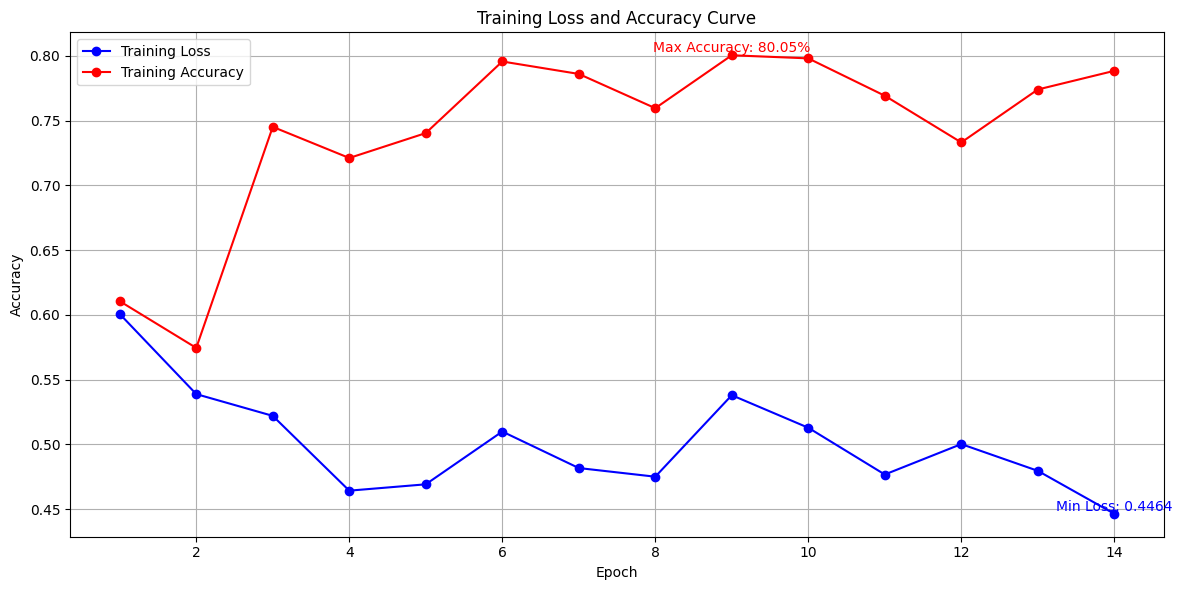

Loaded the best model.


In [15]:
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from statistics import mean

# Lists to store the values for plotting
train_losses = []
train_accuracies = []

best_state = few_shot_classifier.state_dict()
best_training_accuracy = 0.0  # Initialize with 0 as the starting point

# Early stopping parameters
patience = 5
current_patience = patience

for epoch in range(n_epochs):
    print(f"Epoch {epoch}")
    average_loss = training_epoch(few_shot_classifier, train_loader, train_optimizer)
    training_accuracy = evaluate(
        few_shot_classifier, train_loader, device=DEVICE, use_tqdm=False, tqdm_prefix="Training"
    )

    print(f"Epoch {epoch}: Average Loss: {average_loss}, Training Accuracy: {training_accuracy}")

    # Append values for plotting
    train_losses.append(average_loss)
    train_accuracies.append(training_accuracy)

    if training_accuracy > best_training_accuracy:
        best_training_accuracy = training_accuracy
        best_state = few_shot_classifier.state_dict()
        current_patience = patience  # Reset patience when a better model is found
        print(" We found a new best model!")
    else:
        current_patience -= 1

    if current_patience == 0:
        print(f"Early stopping at epoch {epoch} due to lack of improvement.")
        break

    train_scheduler.step()

# Plot the learning curve on the same graph
plt.figure(figsize=(12, 6))

# Plot training loss
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss and Accuracy Curve')
plt.legend()

# Annotate the best training loss point
min_loss_index = train_losses.index(min(train_losses))
plt.text(min_loss_index + 1, min(train_losses), f'Min Loss: {min(train_losses):.4f}', ha='center', va='bottom', color='b')

# Plot training accuracy on the same graph
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy', marker='o', linestyle='-', color='r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Annotate the best training accuracy point
max_acc_index = train_accuracies.index(max(train_accuracies))
plt.text(max_acc_index + 1, max(train_accuracies), f'Max Accuracy: {max(train_accuracies):.2%}', ha='center', va='bottom', color='r')

plt.tight_layout()
plt.grid(True)
plt.show()

# Load the best model state
few_shot_classifier.load_state_dict(best_state)
print("Loaded the best model.")


In [16]:
few_shot_classifier.load_state_dict(best_state)

<All keys matched successfully>

In [17]:
# Set your desired image size
image_size = 224

# Define transforms for the combined dataset
combined_transform = transforms.Compose([
    transforms.RandomResizedCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

# Create instances of your custom dataset for each type with labels
normal1_dataset = LungCancerDataset('/kaggle/input/covid19-image-dataset/Covid19-dataset/train/Normal', label=0, transform=combined_transform)
#cancer1_dataset = LungCancerDataset('/kaggle/input/covid19-image-dataset/Covid19-dataset/test/Covid', label=1, transform=combined_transform)
cancer_dataset = LungCancerDataset('/kaggle/input/covid19-image-dataset/Covid19-dataset/train/Covid', label=1, transform=combined_transform)
# Combine the datasets
test_dataset = ConcatDataset([normal1_dataset,cancer_dataset])
# Create DataLoader instance for the combined dataset
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=0)

In [18]:
# Set the seed for reproducibility
torch.manual_seed(42)

test_size = len(test_dataset)

indices = list(range(test_size))
test_indices = indices[:test_size]

indices = list(range(test_size))
test_indices = indices[:test_size]

# Define the sampler for obtaining test batches
test_sampler = SubsetRandomSampler(test_indices)

# Create DataLoader instance for the test set using the sampler
test_loader = DataLoader(test_dataset, batch_size=64, sampler=test_sampler, num_workers=0, pin_memory=True)

In [19]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(len(class_names), len(class_names)))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def calculate_sensitivity_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tp = cm[1, 1]
    fp = cm[0, 1]
    tn = cm[0, 0]
    fn = cm[1, 0]

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    return sensitivity, specificity

def debug_testing(model: FewShotClassifier, data_loader: DataLoader, device, class_names, use_tqdm=True, tqdm_prefix="Evaluation"):
    total_predictions = 0
    correct_predictions = 0
    y_true = []
    y_pred = []
    model.eval()

    with torch.no_grad():
        with tqdm(
            enumerate(data_loader),
            total=len(data_loader),
            disable=not use_tqdm,
            desc=tqdm_prefix,
        ) as tqdm_eval:
            for batch_idx, (images, labels) in tqdm_eval:
                support_images, query_images = torch.chunk(images, 2, dim=0)
                support_labels, query_labels = torch.chunk(labels, 2, dim=0)

                model.process_support_set(support_images.to(device), support_labels.to(device))
                predictions = model(query_images.to(device))

                _, predicted_labels = torch.max(predictions, 1)
                correct_predictions += (predicted_labels == query_labels.to(device)).sum().item()
                total_predictions += len(query_labels)

                y_true.extend(query_labels.cpu().numpy())
                y_pred.extend(predicted_labels.cpu().numpy())

                print(f"Batch {batch_idx} - Original Labels: {query_labels.cpu().numpy()}, Predicted Labels: {predicted_labels.cpu().numpy()}")

    accuracy = correct_predictions / total_predictions

    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred, class_names)

    # Calculate sensitivity and specificity
    sensitivity, specificity = calculate_sensitivity_specificity(y_true, y_pred)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Sensitivity: {sensitivity * 100:.2f}%')
    print(f'Specificity: {specificity * 100:.2f}%')

    return accuracy

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Evaluation:  33%|███▎      | 1/3 [00:04<00:08,  4.02s/it]

Batch 0 - Original Labels: [0 1 1 0 1 1 1 0 0 0 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0], Predicted Labels: [0 0 1 0 1 1 1 1 0 0 0 1 0 1 0 0 1 0 0 1 0 0 1 0 1 0 1 0 1 1 0 0]


Evaluation:  67%|██████▋   | 2/3 [00:07<00:03,  3.83s/it]

Batch 1 - Original Labels: [0 1 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1], Predicted Labels: [0 0 1 0 0 0 0 1 1 0 0 1 0 0 1 0 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1]


Evaluation: 100%|██████████| 3/3 [00:10<00:00,  3.63s/it]

Batch 2 - Original Labels: [1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1], Predicted Labels: [1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 0 1 1 1 1 1 1]


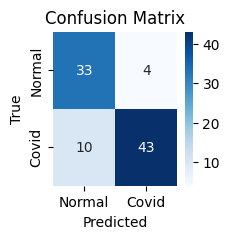

Accuracy: 84.44%
Sensitivity: 81.13%
Specificity: 89.19%
Test Accuracy: 84.44%


In [20]:
# Assuming you have already defined FewShotClassifier, test_loader, device, and class_names

# Call the debug_testing function
accuracy = debug_testing(few_shot_classifier, test_loader, device=DEVICE, class_names=["Normal", "Covid"])
print(f'Test Accuracy: {accuracy * 100:.2f}%')


In [21]:
# Assuming you have a FewShotClassifier named few_shot_classifier

# Specify the file path where you want to save the model
model_path = "/kaggle/working/3shot.pth"

# Save the model
torch.save(few_shot_classifier.state_dict(), model_path)

# Print a message indicating that the model has been saved
print(f"Model saved to {model_path}")


Model saved to /kaggle/working/3shot.pth


In [22]:
# Assuming `few_shot_classifier` is your model
print(few_shot_classifier)


PrototypicalNetworks(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (layer2): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inpl